In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [2]:
#First part of the post-processing procedure consists of integrating the induced current to obtain the total charge collected
#at the electrode

In [3]:
#the function assumes constant time-step, which is the case in the output of my simulations

#integrates using trapezoid rule for 1st and last points, it uses Simpson's rule for the bulk points

def charge_trace(i_signal, time_step):
    
    del_t = time_step*10**(-9)
    
    N = len(i_signal)
    
    charge = []
    time = []
    
    #time step 0
    charge_0 = i_signal[0]*del_t
    
    charge.append(charge_0)
    time.append(round(time_step, 3))
    
    #time step 1
    charge_1 = (i_signal[0] + i_signal[1])*0.5*del_t
    
    charge.append(charge_1)
    time.append(round(2*time_step, 3))
    
    #bulk of the signal
    charge_j = charge_1
    for j in range(2, N-1):
        
        i_0 = i_signal[j-1]
        i_1 = i_signal[j]
        i_2 = i_signal[j+1]
        
        charge_j = charge_j + ((8*i_1+5*i_2-i_0)/12)*del_t #Simpson's rule in incremental form, integration over a single slice
        
        charge.append(charge_j)
        time.append(round((j+1)*time_step, 3))
        
    #last term
    charge_N = (i_signal[N-2] + i_signal[N-1])*0.5*del_t
    
    charge_tot = charge[-1] + charge_N
    
    charge.append(charge_tot)
    time.append(round(N*time_step, 3))
    
    #real charge is the opposite of the calculated one from the curernt!
    #for p in range(len(charge)):
        #charge[p] = -charge[p]
    
    time_series = [time, charge] #output is list of lists
    
    return time_series

In [4]:
#convolution of the idealised voltage signal with the time-response of the CSA
#Use full trapezoid rule for integration

def real_signal(V_signal, time_step, time_const):
    
    V_real = []
    
    N = len(V_signal)
    
    M = int((time_const/time_step)*10)
    
    def res(n):
        
        t = n*time_step
        
        response = (np.exp(t/time_const))/time_const
        
        return response
    
    def neg_exp(n):
        
        t = -n*time_step
        
        out = np.exp(t/time_const)
        
        return out
        
    #timestep 0
    
    V_0 = V_signal[0]
    V_1 = V_signal[0]
    
    V_out = neg_exp(1)*(V_0*res(0) + V_1*res(1))*0.5*time_step
    V_real.append(V_out)
    
    for m in range(1, N):
        
        V_m_1 = V_signal[m-1]
        V_m = V_signal[m]
        
        V_out = neg_exp(1)*V_real[m-1] + neg_exp(m+1)*(V_m_1*res(m) + V_m*res(m+1))*0.5*time_step
        V_real.append(V_out)
    
    V_N_1 = V_signal[N-2]
    V_N = V_signal[N-1]
    for m in range(M):
        j = N + m
        
        V_out = neg_exp(1)*V_real[j-1] + neg_exp(j+1)*(V_N_1*res(j) + V_N*res(j+1))*0.5*time_step
        V_real.append(V_out)
    
    return V_real

In [5]:
#Define the parameters for a real detector

C_f = 1*10**(-12) #feedback capacitance
C_d = 100*10**(-12) #detector capacitance, strip length = 5cm
C_inter = 7.5*10**(-12) #interstrip capacitance

A = 1000
C_in = (A+1)*C_f

time_const = 0.5*(C_d/C_f)#ns given a GBW product of 2GHz

#time steps (ns)
time_step_h = 0.006
time_step_e = 0.002

In [6]:
#here we are condsidering the situations where i-signal is known

#holes
df_h = pd.read_csv("hole_net_charge_x=50_y=125_diff_trap_nb.csv", header = None) #import signal file
df_h = np.array(df_h)

charge_h_ideal = []
for m in df_h[1, 0:1273]:
    charge_h_ideal.append(m)
time_h_ideal = []
for m in df_h[0, 0:1273]:
    time_h_ideal.append(m)

for m in range(len(charge_h_ideal)):
    charge_h_ideal[m] = charge_h_ideal[m] - df_h[1, 0]
    
for i in range(50):
    charge_h_ideal.append(charge_h_ideal[-1])
    time_h_ideal.append(round(time_h_ideal[-1]+0.006, 3))

#electrons
df_e = pd.read_csv("electron_net_charge_x=50_y=125_diff_trap_nb.csv", header = None) #import signal file
df_e = np.array(df_e)

charge_e_ideal = []
for m in df_e[1, :]:
    charge_e_ideal.append(m)
time_e_ideal = []
for m in df_e[0, :]:
    time_e_ideal.append(m)

for m in range(len(charge_e_ideal)):
    charge_e_ideal[m] = charge_e_ideal[m] - df_e[1, 0]

In [7]:
charge_h_real = real_signal(charge_h_ideal, time_step_h, time_const)
charge_e_real = real_signal(charge_e_ideal, time_step_e, time_const)

7.932
7.8239999999997245
3966
3966
electron charge = 1.8193519747560915e-17
hole charge = -1.6056747677691297e-17


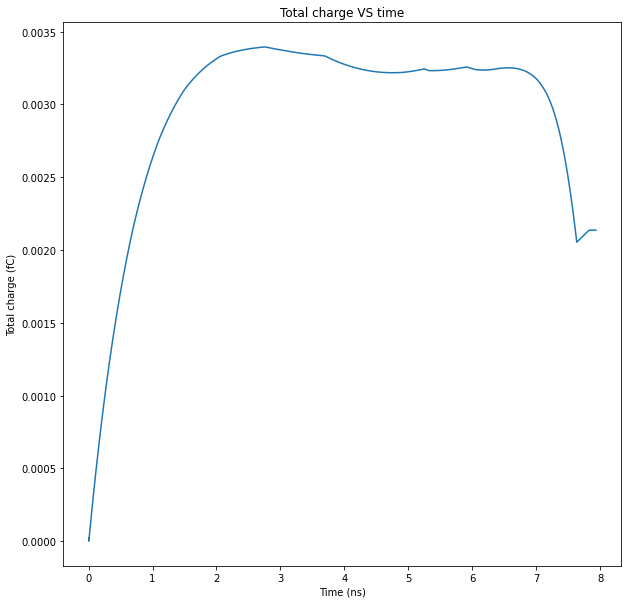

In [8]:
#total ideal charge

last_h_ideal = time_h_ideal[-1]
last_e_ideal = time_e_ideal[-1]

print(last_h_ideal)
print(last_e_ideal)

#electrons
diff_t_ideal = last_h_ideal - last_e_ideal
N_extra_ideal = int(diff_t_ideal/time_step_e)

for m in range(N_extra_ideal-1):
    charge_e_ideal.append(charge_e_ideal[-1])
    
#holes
g = interp1d(time_h_ideal, charge_h_ideal, kind = "linear")

new_charge_h_ideal = [charge_h_ideal[0], charge_h_ideal[0]]
for t in np.arange(time_step_h, time_h_ideal[-1]+time_step_e, time_step_e):
    new_charge_h_ideal.append(g(t))

#total charge
total_charge_ideal = []

print(len(charge_e_ideal))
print(len(new_charge_h_ideal))

for i in range(len(new_charge_h_ideal)):
    total_charge_ideal.append(charge_e_ideal[i] + new_charge_h_ideal[i])

total_charge_plot = []
for i in total_charge_ideal:
    total_charge_plot.append(i*10**(15))

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
var = np.arange(time_step_e, time_h_ideal[-1]+time_step_e, time_step_e)
ax.plot(var, total_charge_plot)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Total charge (fC)")
ax.set_title("Total charge VS time")
plt.savefig("total_induced_charge_x=0_y=125_diff_trap_nb.jpeg")

print("electron charge = " + str(charge_e_ideal[-1]))
print("hole charge = " + str(new_charge_h_ideal[-1]))

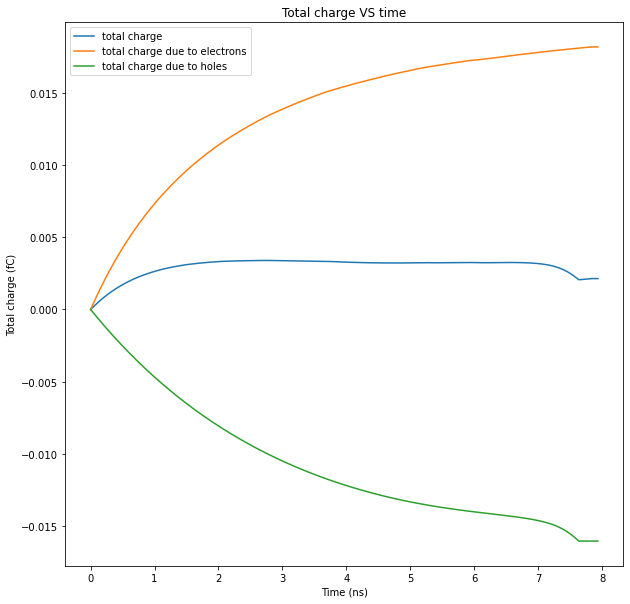

In [9]:
charge_e_plot = []
for i in charge_e_ideal:
    charge_e_plot.append(i*10**(15))
    
charge_h_plot = []
for i in new_charge_h_ideal:
    charge_h_plot.append(i*10**(15))

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.plot(var, total_charge_plot, label = "total charge")
ax.plot(var, charge_e_plot, label = "total charge due to electrons")
ax.plot(var, charge_h_plot, label = "total charge due to holes")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Total charge (fC)")
ax.set_title("Total charge VS time")
ax.legend()
plt.savefig("comparison_induced_charge_x=50_y=125_diff_trap_nb.jpeg")

In [10]:
#work on the lists of real signals in order to produce the total charge

last_h = len(charge_h_real)*time_step_h
last_e = len(charge_e_real)*time_step_e
print(last_h)
print(last_e)

time_h = np.arange(time_step_h, last_h+time_step_h, time_step_h)

#electrons
diff_t = last_h - last_e
N_extra = int(diff_t/time_step_e)

for m in range(N_extra+1):
    charge_e_real.append(charge_e_real[-1])

#holes
f = interp1d(time_h, charge_h_real, kind = "linear")
stop = 1000

new_charge_h_real = [charge_h_real[0], charge_h_real[0]]
for n in np.arange(time_step_h, last_h-stop*time_step_h, time_step_e):
    new_charge_h_real.append(f(n))

for i in range(3*stop+1):
    new_charge_h_real.append(new_charge_h_real[-1])


#total charge
total_charge = []

print(len(charge_e_real))
print(len(new_charge_h_real))

for i in range(len(new_charge_h_real)):
    total_charge.append(new_charge_h_real[i] + charge_e_real[i])

507.93600000000004
507.826
253969
253969


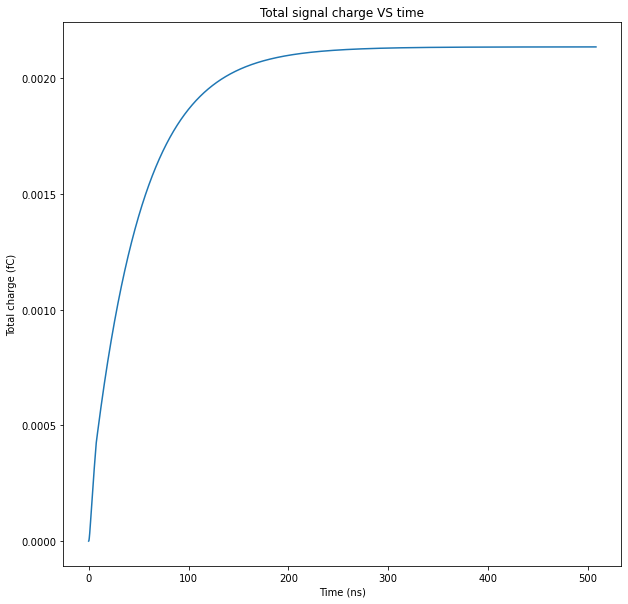

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

time = np.arange(0, round(last_h+time_step_e, 3), time_step_e)
total_charge_plot = []
for i in total_charge:
    total_charge_plot.append(i*10**(15))

ax.plot(time, total_charge_plot)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Total charge (fC)")
ax.set_title("Total signal charge VS time")
plt.savefig("charge_collection_response_x=50_y=125_diff_trap_nb.jpeg")

In [12]:
#total charge at amplifier and total residual charge
collect_fraction = 1/(1+C_d/C_in)

total_charge_amplifier = []
for i in total_charge:
    total_charge_amplifier.append(collect_fraction*i)

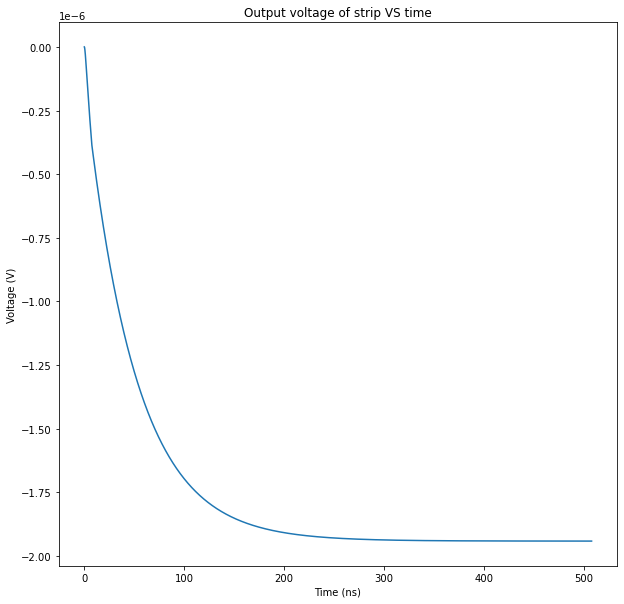

In [13]:
#Output voltage amplifier

V_out_amplifier = []
for i in total_charge_amplifier:
    V_out_amplifier.append(-(1/C_f)*i)
    
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.plot(time, V_out_amplifier)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Voltage (V)")
ax.set_title("Output voltage of strip VS time")
plt.savefig("voltage_output_x=50_y=125_diff_trap_nb.jpeg")

output_voltage_amp = [time, V_out_amplifier]
np.savetxt("voltage_out_x=50_y=125_diff_trap_nb.csv", output_voltage_amp, delimiter = ",")

In [14]:
#cross talk
#must be very careful here - must consider the ideal total current along with the circuit response

charge_cross = []

M = len(total_charge_ideal)
N = len(total_charge_amplifier)

#adjust ideal charge array
for n in range(N-M):
    total_charge_ideal.append(total_charge_ideal[-1])

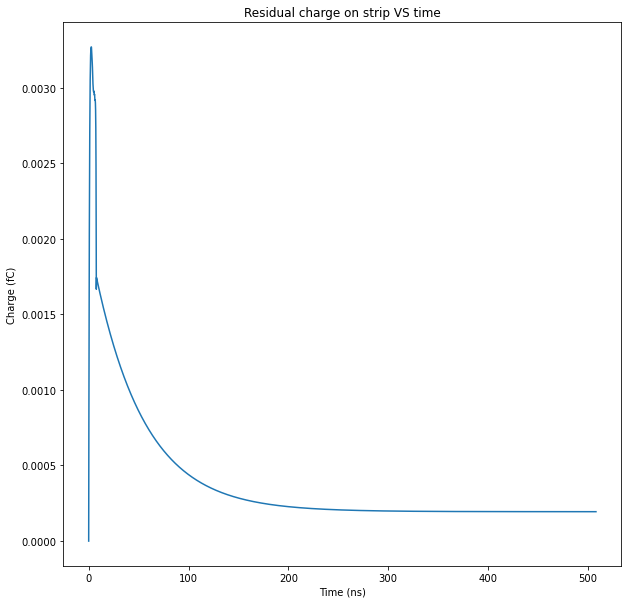

In [15]:
residual_charge = []
for i in range(N):
    residual_charge.append(total_charge_ideal[i]-total_charge_amplifier[i])
    
residual_charge_plot = []
for i in residual_charge:
    residual_charge_plot.append(i*10**(15))
    
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.plot(time, residual_charge_plot)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Charge (fC)")
ax.set_title("Residual charge on strip VS time")
plt.savefig("residual_charge_x=50_y=125_diff_trap_nb.jpeg")

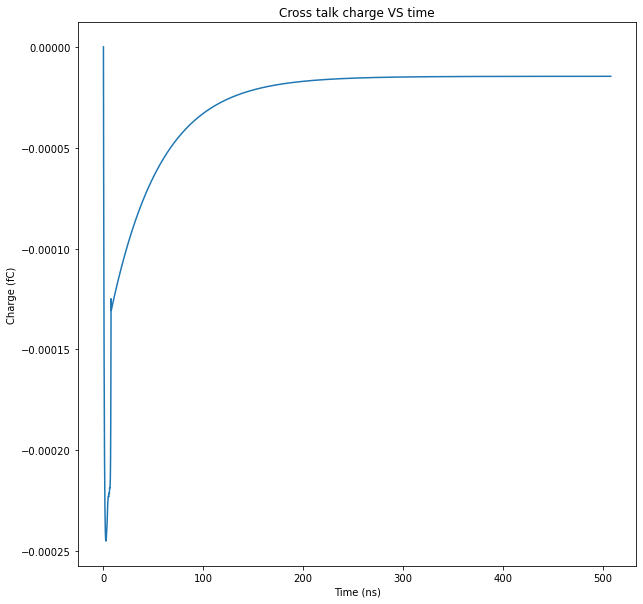

In [16]:
charge_cross = []
for i in range(N):
    charge_cross.append(-(C_inter/C_d)*residual_charge[i])
    
charge_cross_plot = []
for i in charge_cross:
    charge_cross_plot.append(i*10**(15))
    
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.plot(time, charge_cross_plot)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Charge (fC)")
ax.set_title("Cross talk charge VS time")
plt.savefig("cross_talk_charge_x=50_y=125_diff_trap_nb.jpeg")

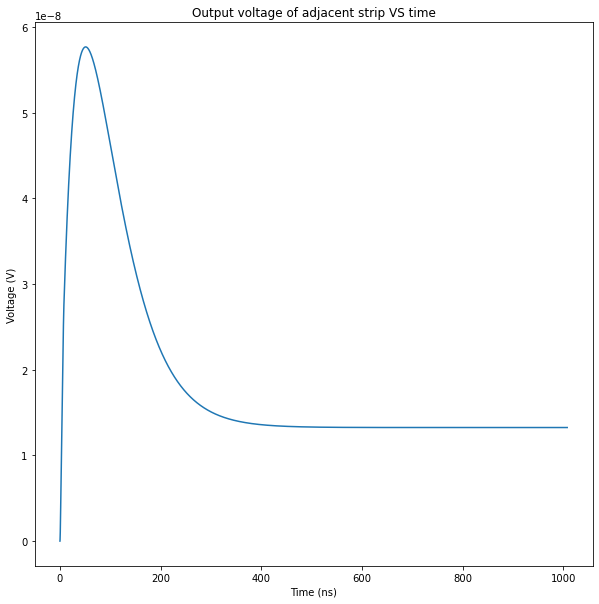

In [17]:
#amplifier response in the adjacent strip
signal_charge_cross = real_signal(charge_cross, time_step_e, time_const)
last_sig  = len(signal_charge_cross)*time_step_e

V_out_cross_amplifier = []
for i in signal_charge_cross:
    V_out_cross_amplifier.append(-(1/C_f)*collect_fraction*i)
    
time_sig = np.arange(time_step_e, last_sig+time_step_e, time_step_e)

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.plot(time_sig, V_out_cross_amplifier)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Voltage (V)")
ax.set_title("Output voltage of adjacent strip VS time")

plt.savefig("cross_talk_signal_x=50_y=125_diff_trap_nb.jpeg")

cross_talk_voltage = [time_sig, V_out_cross_amplifier]
np.savetxt("cross_talk_x=50_y=125_diff_trap_nb.csv", output_voltage_amp, delimiter = ",")